In [26]:
from __future__ import print_function

%matplotlib inline

import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

In [27]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)


In [28]:
sagemaker_session = sagemaker.Session()

In [29]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_prefix = "deepar-sales-demo-notebook"  # prefix used for all data stored within the bucket

role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [30]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [10]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)

In [37]:
data = pd.read_csv('train.csv', index_col=2, parse_dates=True )

In [38]:
data

,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
Order Date,,,,,,,,,,,,,,,,,
2017-08-11,1,CA-2017-152156,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
2017-08-11,2,CA-2017-152156,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2017-12-06,3,CA-2017-138688,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
2016-11-10,4,US-2016-108966,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
2016-11-10,5,US-2016-108966,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-21,9796,CA-2017-125920,28/05/2017,Standard Class,SH-19975,Sally Hughsby,Corporate,United States,Chicago,Illinois,60610.0,Central,OFF-BI-10003429,Office Supplies,Binders,"Cardinal HOLDit! Binder Insert Strips,Extra St...",3.7980
2016-12-01,9797,CA-2016-128608,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,OFF-AR-10001374,Office Supplies,Art,"BIC Brite Liner Highlighters, Chisel Tip",10.3680
2016-12-01,9798,CA-2016-128608,17/01/2016,Standard Class,CS-12490,Cindy Schnelling,Corporate,United States,Toledo,Ohio,43615.0,East,TEC-PH-10004977,Technology,Phones,GE 30524EE4,235.1880


In [39]:
num_timeseries = data.shape[1]

In [46]:
num_timeseries=3

In [47]:
data_sales = data.resample("2H").sum() / 8
data_sales.head(20)

,Row ID,Postal Code,Sales
Order Date,,,
2015-01-02 00:00:00,67.625,6787.75,58.612500
2015-01-02 02:00:00,0.000,0.00,0.000000
2015-01-02 04:00:00,0.000,0.00,0.000000
2015-01-02 06:00:00,0.000,0.00,0.000000
2015-01-02 08:00:00,0.000,0.00,0.000000
2015-01-02 10:00:00,0.000,0.00,0.000000
2015-01-02 12:00:00,0.000,0.00,0.000000
2015-01-02 14:00:00,0.000,0.00,0.000000
2015-01-02 16:00:00,0.000,0.00,0.000000


In [ ]:
data_s

In [48]:
timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data_sales.iloc[:, i], trim="f"))

In [49]:
timeseries

[Order Date
 2015-01-02 00:00:00      67.625
 2015-01-02 02:00:00       0.000
 2015-01-02 04:00:00       0.000
 2015-01-02 06:00:00       0.000
 2015-01-02 08:00:00       0.000
                          ...   
 2018-12-29 16:00:00       0.000
 2018-12-29 18:00:00       0.000
 2018-12-29 20:00:00       0.000
 2018-12-29 22:00:00       0.000
 2018-12-30 00:00:00    1382.125
 Freq: 2H, Name: Row ID, Length: 17497, dtype: float64,
 Order Date
 2015-01-02 00:00:00     6787.75
 2015-01-02 02:00:00        0.00
 2015-01-02 04:00:00        0.00
 2015-01-02 06:00:00        0.00
 2015-01-02 08:00:00        0.00
                          ...   
 2018-12-29 16:00:00        0.00
 2018-12-29 18:00:00        0.00
 2018-12-29 20:00:00        0.00
 2018-12-29 22:00:00        0.00
 2018-12-30 00:00:00    43354.00
 Freq: 2H, Name: Postal Code, Length: 17497, dtype: float64,
 Order Date
 2015-01-02 00:00:00    58.61250
 2015-01-02 02:00:00     0.00000
 2015-01-02 04:00:00     0.00000
 2015-01-02 06:00:00  

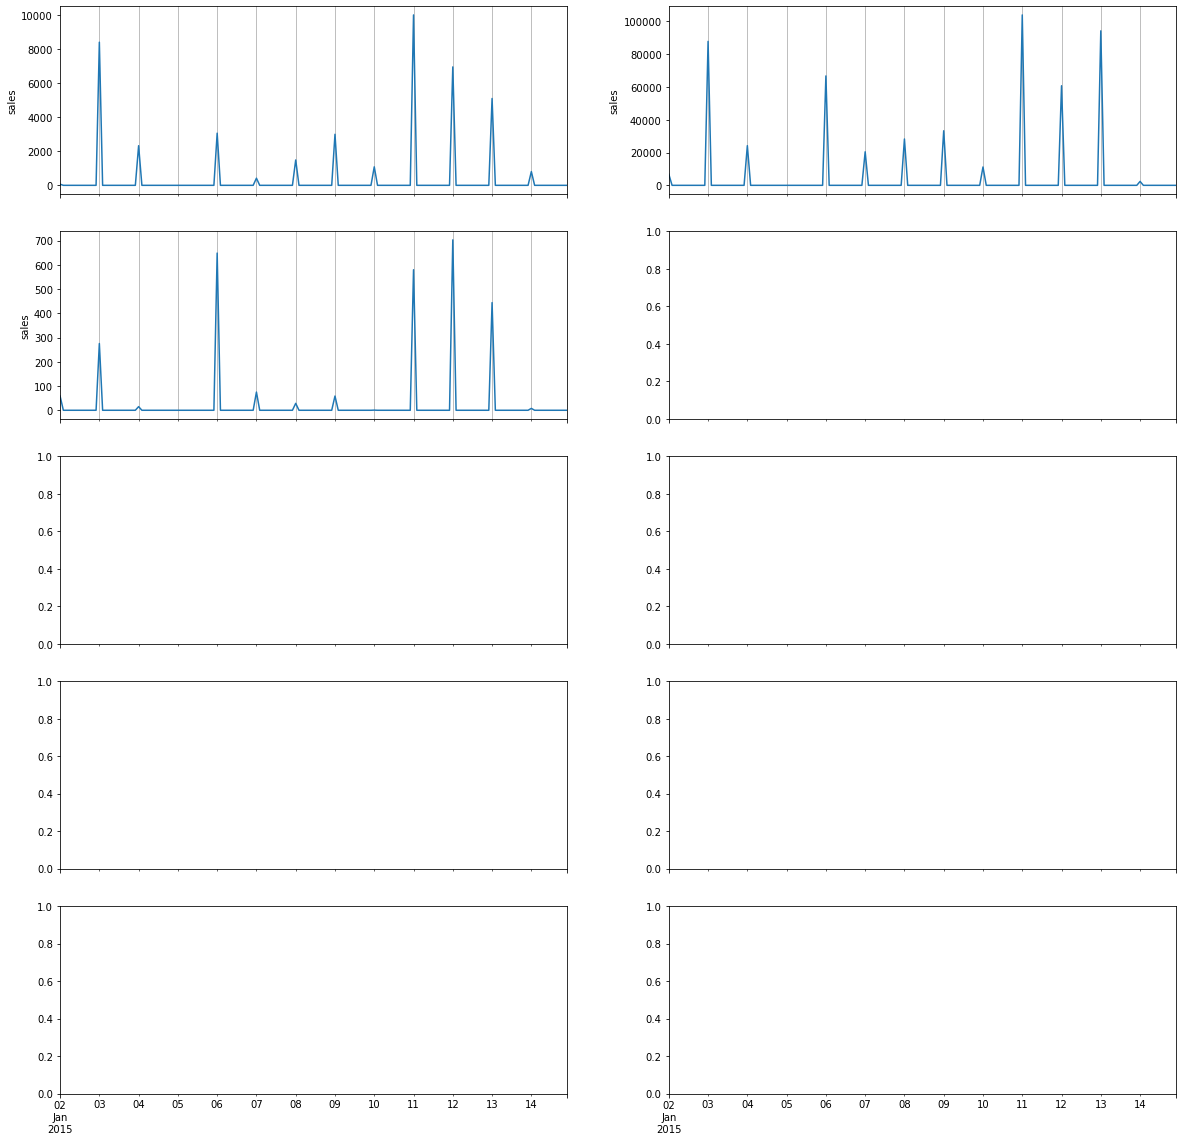

In [96]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 3):
    timeseries[i].loc["2015-01-01":"2015-01-14"].plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel("sales")
    axx[i].grid(which="minor", axis="x")

In [53]:
# we use 2 hour frequency for the time series
freq = "2H"

# we predict for 7 days
prediction_length = 7 * 12

# we also use 7 days as context length, this is the number of state updates accomplished before making predictions
context_length = 7 * 12

In [54]:
start_dataset = pd.Timestamp("2015-01-02 00:00:00", freq=freq)
end_training = pd.Timestamp("2018-03-13 00:00:00", freq=freq)

/tmp/ipykernel_4272/3397719331.py:1: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start_dataset = pd.Timestamp("2015-01-02 00:00:00", freq=freq)
/tmp/ipykernel_4272/3397719331.py:2: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  end_training = pd.Timestamp("2018-03-13 00:00:00", freq=freq)


In [55]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[
            start_dataset : end_training - timedelta(days=1)
        ].tolist(),  # We use -1, because pandas indexing includes the upper bound
    }
    for ts in timeseries
]
print(len(training_data))

3


In [56]:
num_test_windows = 4

test_data = [
    {
        "start": str(start_dataset),
        "target": ts[start_dataset : end_training + timedelta(days=k * prediction_length)].tolist(),
    }
    for k in range(1, num_test_windows + 1)
    for ts in timeseries
]
print(len(test_data))

12


In [57]:
def write_dicts_to_file(path, data):
    with open(path, "wb") as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode("utf-8"))

In [58]:
%%time
write_dicts_to_file("train.json", training_data)
write_dicts_to_file("test.json", test_data)

CPU times: user 41.4 ms, sys: 0 ns, total: 41.4 ms
Wall time: 40.7 ms


In [59]:
s3 = boto3.resource("s3")


def copy_to_s3(local_file, s3_path, override=False):
    assert s3_path.startswith("s3://")
    split = s3_path.split("/")
    bucket = split[2]
    path = "/".join(split[3:])
    buk = s3.Bucket(bucket)

    if len(list(buk.objects.filter(Prefix=path))) > 0:
        if not override:
            print(
                "File s3://{}/{} already exists.\nSet override to upload anyway.\n".format(
                    s3_bucket, s3_path
                )
            )
            return
        else:
            print("Overwriting existing file")
    with open(local_file, "rb") as data:
        print("Uploading file to {}".format(s3_path))
        buk.put_object(Key=path, Body=data)

In [60]:
%%time
copy_to_s3("train.json", s3_data_path + "/train/train.json")
copy_to_s3("test.json", s3_data_path + "/test/test.json")

Uploading file to s3://sagemaker-us-east-1-101718508260/deepar-sales-demo-notebook/data/train/train.json
Uploading file to s3://sagemaker-us-east-1-101718508260/deepar-sales-demo-notebook/data/test/test.json
CPU times: user 40.3 ms, sys: 0 ns, total: 40.3 ms
Wall time: 252 ms


In [61]:
s3_sample = s3.Object(s3_bucket, s3_prefix + "/data/train/train.json").get()["Body"].read()
StringVariable = s3_sample.decode("UTF-8", "ignore")
lines = StringVariable.split("\n")
print(lines[0][:100] + "...")

{"start": "2015-01-02 00:00:00", "target": [67.625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...


In [62]:
estimator = sagemaker.estimator.Estimator(
    image_uri=image_name,
    sagemaker_session=sagemaker_session,
    role=role,
    train_instance_count=1,
    train_instance_type="ml.c4.2xlarge",
    base_job_name="deepar-sales-demo",
    output_path=s3_output_path,
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [63]:
hyperparameters = {
    "time_freq": freq,
    "epochs": "400",
    "early_stopping_patience": "40",
    "mini_batch_size": "64",
    "learning_rate": "5E-4",
    "context_length": str(context_length),
    "prediction_length": str(prediction_length),
}

In [64]:
estimator.set_hyperparameters(**hyperparameters)

In [65]:
%%time
data_channels = {"train": "{}/train/".format(s3_data_path), "test": "{}/test/".format(s3_data_path)}

estimator.fit(inputs=data_channels, wait=True)

2022-09-18 16:34:12 Starting - Starting the training job...
2022-09-18 16:34:37 Starting - Preparing the instances for trainingProfilerReport-1663518852: InProgress
......
2022-09-18 16:35:38 Downloading - Downloading input data...
2022-09-18 16:35:58 Training - Downloading the training image......
2022-09-18 16:37:09 Training - Training image download completed. Training in progress..Arguments: train
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:78: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
/opt/amazon/lib/python3.8/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[09/18/2022 16:37:15 INFO 140718936323904] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.j

In [66]:
from sagemaker.serializers import IdentitySerializer

In [67]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    def __init__(self, *args, **kwargs):
        super().__init__(
            *args,
            # serializer=JSONSerializer(),
            serializer=IdentitySerializer(content_type="application/json"),
            **kwargs,
        )

    def predict(
        self,
        ts,
        cat=None,
        dynamic_feat=None,
        num_samples=100,
        return_samples=False,
        quantiles=["0.1", "0.5", "0.9"],
    ):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.

        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])

        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(
            ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None
        )

        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles,
        }

        http_request_data = {"instances": [instance], "configuration": configuration}

        return json.dumps(http_request_data).encode("utf-8")
    
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode("utf-8"))["predictions"][0]
        prediction_length = len(next(iter(predictions["quantiles"].values())))
        prediction_index = pd.date_range(
            start=prediction_time, freq=freq, periods=prediction_length
        )
        if return_samples:
            dict_of_samples = {"sample_" + str(i): s for i, s in enumerate(predictions["samples"])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(
            data={**predictions["quantiles"], **dict_of_samples}, index=prediction_index
        )
    
    def set_frequency(self, freq):
        self.freq = freq


def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]


def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat
    return obj


In [69]:
predictor = estimator.deploy(
    initial_instance_count=1, instance_type="ml.m5.large", predictor_cls=DeepARPredictor
)

------!

In [83]:
predictor.predict(ts=timeseries[2], quantiles=[0.10, 0.5, 0.90]).head()

,0.1,0.5,0.9
2018-12-30 02:00:00,-0.226100,-0.007297,0.175329
2018-12-30 04:00:00,-0.172893,-0.015433,0.109206
2018-12-30 06:00:00,-0.119177,-0.010195,0.089974
2018-12-30 08:00:00,-0.061439,0.020356,0.099211
2018-12-30 10:00:00,-0.050779,0.015012,0.064644


In [89]:
predictor.predict(ts=timeseries[2], quantiles=[0.10, 0.5, 0.90])

,0.1,0.5,0.9
2018-12-30 02:00:00,-0.226100,-0.007297,0.175329
2018-12-30 04:00:00,-0.172893,-0.015433,0.109206
2018-12-30 06:00:00,-0.119177,-0.010195,0.089974
2018-12-30 08:00:00,-0.061439,0.020356,0.099211
2018-12-30 10:00:00,-0.050779,0.015012,0.064644
...,...,...,...
2019-01-05 16:00:00,-0.070191,-0.009156,0.073515
2019-01-05 18:00:00,-0.068202,-0.006418,0.070176
2019-01-05 20:00:00,-0.053795,-0.000758,0.066665
2019-01-05 22:00:00,-0.220906,0.105821,2.949383


In [90]:
timeseries

[Order Date
 2015-01-02 00:00:00      67.625
 2015-01-02 02:00:00       0.000
 2015-01-02 04:00:00       0.000
 2015-01-02 06:00:00       0.000
 2015-01-02 08:00:00       0.000
                          ...   
 2018-12-29 16:00:00       0.000
 2018-12-29 18:00:00       0.000
 2018-12-29 20:00:00       0.000
 2018-12-29 22:00:00       0.000
 2018-12-30 00:00:00    1382.125
 Freq: 2H, Name: Row ID, Length: 17497, dtype: float64,
 Order Date
 2015-01-02 00:00:00     6787.75
 2015-01-02 02:00:00        0.00
 2015-01-02 04:00:00        0.00
 2015-01-02 06:00:00        0.00
 2015-01-02 08:00:00        0.00
                          ...   
 2018-12-29 16:00:00        0.00
 2018-12-29 18:00:00        0.00
 2018-12-29 20:00:00        0.00
 2018-12-29 22:00:00        0.00
 2018-12-30 00:00:00    43354.00
 Freq: 2H, Name: Postal Code, Length: 17497, dtype: float64,
 Order Date
 2015-01-02 00:00:00    58.61250
 2015-01-02 02:00:00     0.00000
 2015-01-02 04:00:00     0.00000
 2015-01-02 06:00:00  

In [13]:
data = pd.read_csv('sales.csv', index_col=0, parse_dates=True )
num_timeseries = data.shape[1]
data_sales = data.resample("D").sum()
timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data_sales.iloc[:, i], trim="f"))

In [25]:
data.head()

,Sales
Order Date,
2015-01-02,468.900
2015-01-03,5.940
2015-01-03,457.568
2015-01-03,17.472
2015-01-03,63.552


In [14]:
timeseries

[Order Date
 2015-01-02     468.9000
 2015-01-03    2203.1510
 2015-01-04     119.8880
 2015-01-05       0.0000
 2015-01-06    5188.5200
                 ...    
 2018-12-26     814.5940
 2018-12-27     177.6360
 2018-12-28    1657.3508
 2018-12-29    2915.5340
 2018-12-30     713.7900
 Freq: D, Name: Sales, Length: 1459, dtype: float64]

In [24]:
num_timeseries

1

In [19]:
"""fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    timeseries[i].loc["2015-01-02 ":"2015-01-13"].plot(ax=axx[i])
    axx[i].set_xlabel("date")
    axx[i].set_ylabel("Sales")
    axx[i].grid(which="minor", axis="x")"""

'fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)\naxx = axs.ravel()\nfor i in range(0, 10):\n    timeseries[i].loc["2015-01-02 ":"2015-01-13"].plot(ax=axx[i])\n    axx[i].set_xlabel("date")\n    axx[i].set_ylabel("Sales")\n    axx[i].grid(which="minor", axis="x")'

In [20]:
# we use 1 day frequency for the time series
freq = "D"

# we predict for 150 days
prediction_length = 150

# we also use 7 days as context length, this is the number of state updates accomplished before making predictions
context_length = 365

In [22]:
start_dataset =pd.Timestamp("2015-01-02")
end_training = pd.Timestamp("2018-03-13")

In [23]:
training_data = [
    {
        "start": str(start_dataset),
        "target": ts[
            start_dataset : end_training - timedelta(days=1)
        ].tolist(),  # We use -1, because pandas indexing includes the upper bound
    }
    for ts in timeseries
]
print(len(training_data))

1
